## Image classification via fine-tuning with EfficientNet

### Setup

In [ ]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torchsummary import summary
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import datasets,transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Downloading data

In [4]:
!curl -O vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!tar -xf images.tar
!mv Images StanfordDogs

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  756M  100  756M    0     0  9149k      0  0:01:24  0:01:24 --:--:-- 7704k


### Loading data

In [5]:
def find_mean_std(train_loader):
    mean = 0.0
    std = 0.0
    total_samples = 0

    for data, _ in train_loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples

    return mean, std

In [6]:
class StanfordDogsDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None, train=True):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.train = train

        self.files = []
        self.labels = []
        self.class_names = []
        self.index_to_clssname = {}

        for index, folder_name in enumerate(glob.glob(os.path.join(self.root, "*"))):
            class_index = index
            class_name = folder_name.split("-")[1]
            self.index_to_clssname[class_index] = class_name

            for img_path in glob.glob(os.path.join(folder_name, "*.jpg")):
                self.files.append(img_path)
                self.labels.append(class_index)

        indices = list(range(len(self.files)))
        random.seed(42)
        random.shuffle(indices)
        self.files = [self.files[i] for i in indices]
        self.labels = [self.labels[i] for i in indices]

        n_samples = len(self.files)

        if train:
            self.files = self.files[:int(0.8 * n_samples)]
        else:
            self.files = self.files[int(0.8 * n_samples):]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image_path = self.files[index]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 120
data_path = "StanfordDogs"

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

train_dataset = StanfordDogsDataset(data_path, transform, train=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

mean, std = find_mean_std(train_loader)

print("Mean:", mean.tolist())
print("Std:", std.tolist())

Mean: [0.47689035534858704, 0.4526151418685913, 0.39156216382980347]
Std: [0.22605925798416138, 0.22127209603786469, 0.21976327896118164]


### Visualizing the data

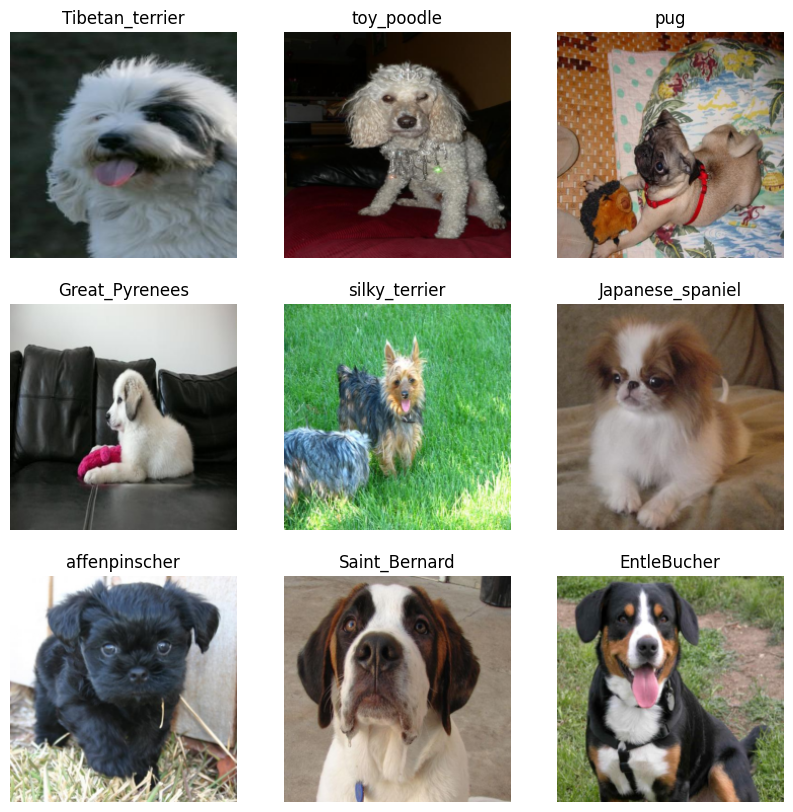

In [8]:
def find_label(label):
    return train_dataset.index_to_clssname.get(int(label))

plt.figure(figsize=(10, 10))
for images, labels in train_loader:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        plt.title(find_label(labels[i]))
        plt.axis("off")
    break
plt.show()

### Data augmentation

In [9]:
data_augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(contrast=0.1)])

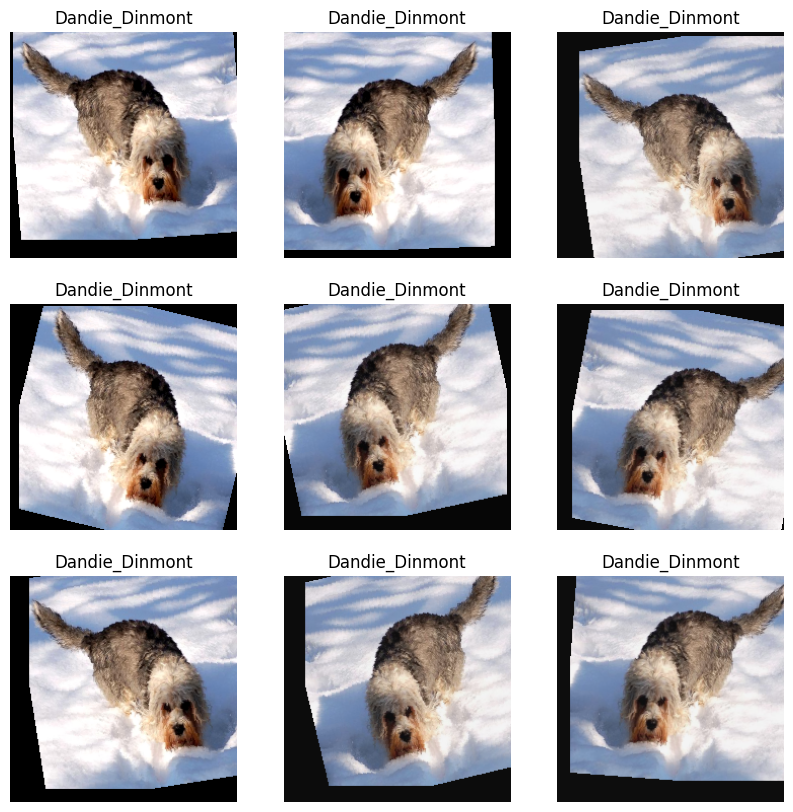

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_loader:
    for i in range(9):
        augmented_images = data_augmentation_transforms(images)
        ax = plt.subplot(3, 3, i + 1)

        plt.imshow(np.transpose(augmented_images[0].numpy(), (1, 2, 0)))
        plt.title(find_label(labels[0]))
        plt.axis("off")
    break
plt.show()

### Prepare inputs

In [11]:
train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    data_augmentation_transforms,
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

target_transform = transforms.Lambda(lambda label: F.one_hot(torch.tensor(label), NUM_CLASSES))

train_dataset = StanfordDogsDataset(data_path, train_transform, target_transform, train=True)
test_dataset = StanfordDogsDataset(data_path, test_transform, target_transform, train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training a model from scratch

In [ ]:
model = efficientnet_b0(dropout=0.4)

In [ ]:
model.classifier[1] = nn.Linear(1280, NUM_CLASSES)

In [12]:
def run(model, normal_init=False, learning_rate=1e-3):
  torch.manual_seed(42)
  model.to(device=device)

  learning_rate = learning_rate
  num_epochs = 10

  def init_weight(m):
    if isinstance(m, nn.Linear):
      nn.init.kaiming_normal_(m.weight)
      nn.init.zeros_(m.bias)

  if normal_init:
    model.apply(init_weight)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  best_accuracy = 0.0
  patience = 5
  epoch_num_improve = 0

  train_losses = []
  train_accuracies = []
  test_losses = []
  test_accuracies = []

  for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in tqdm(train_loader):
      images = images.to(device=device)
      labels = labels.type(torch.FloatTensor).to(device=device)

      output = model(images)

      loss = criterion(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

      _, predicted = torch.max(output.data, 1)
      labels = torch.argmax(labels)
      train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(train_dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss = 0
    test_correct = 0

    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device=device)
        labels = labels.type(torch.FloatTensor).to(device=device)


        output = model(images)
        loss = criterion(output, labels)

        test_loss += loss.item()

      _, predicted = torch.max(output.data, 1)
      labels = torch.argmax(labels)
      test_correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = test_correct / len(test_dataset)
    test_losses.append(test_loss)
    train_accuracies.append(test_accuracy)

    print(f"Epoch: {epoch + 1}/{num_epochs} | Train loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Test loss: {test_loss:.4f} | Test Acc: {test_accuracy:.4f}")

    if test_accuracy > best_accuracy:
      best_accuracy = test_accuracy
      epoch_num_improve = 0
      torch.save(model.state_dict(), "best_model.pth")
    else:
      epoch_num_improve += 1
      if epoch_num_improve > patience:
        print(f"Early stopping, best accuracy {best_accuracy}")
        break
  return train_losses, train_accuracies, test_losses, test_accuracies

In [ ]:
train_losses, train_accuracies, test_losses, test_accuracies = run(model, normal_init=True)

100%|██████████| 515/515 [02:50<00:00,  3.01it/s]


Epoch: 1/10 | Train loss: 4.6655 | Train Acc: 0.0109 | Test loss: 5.1335 | Test Acc: 0.0005


100%|██████████| 515/515 [02:51<00:00,  3.01it/s]


Epoch: 2/10 | Train loss: 4.4074 | Train Acc: 0.0110 | Test loss: 5.4389 | Test Acc: 0.0000


100%|██████████| 515/515 [02:50<00:00,  3.01it/s]


Epoch: 3/10 | Train loss: 4.1569 | Train Acc: 0.0098 | Test loss: 6.1578 | Test Acc: 0.0000


100%|██████████| 515/515 [02:51<00:00,  3.00it/s]


Epoch: 4/10 | Train loss: 3.9798 | Train Acc: 0.0101 | Test loss: 6.0963 | Test Acc: 0.0002


100%|██████████| 515/515 [02:52<00:00,  2.99it/s]


Epoch: 5/10 | Train loss: 3.8394 | Train Acc: 0.0098 | Test loss: 6.4750 | Test Acc: 0.0000


100%|██████████| 515/515 [02:55<00:00,  2.93it/s]


Epoch: 6/10 | Train loss: 3.6944 | Train Acc: 0.0105 | Test loss: 6.5968 | Test Acc: 0.0000


100%|██████████| 515/515 [02:50<00:00,  3.01it/s]


Epoch: 7/10 | Train loss: 3.5284 | Train Acc: 0.0108 | Test loss: 6.9146 | Test Acc: 0.0000
Early stopping, best accuracy 0.00048590864917395527


In [19]:
def plot(train_accuracies, test_accuracies, title, y_label):
    plt.plot(train_accuracies)
    plt.plot(test_accuracies)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

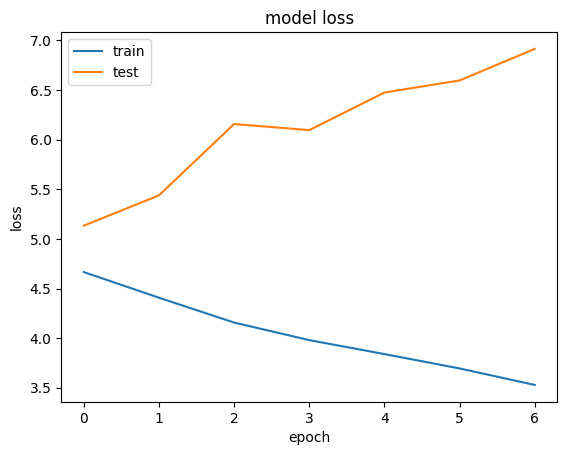

In [ ]:
plot(train_losses, test_losses, title="model loss", y_label="loss")

### Transfer learning from pre-trained weights

In [13]:
model2 = efficientnet_b0(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 98.8MB/s]


In [14]:
for model in model2.features:
    for parameter in model.parameters():
        parameter.requires_grad = False

In [15]:
model2.classifier = nn.Sequential(
    nn.BatchNorm1d(1280),
    nn.Dropout1d(p=0.2, inplace=True),
    nn.Linear(1280, NUM_CLASSES),
)

In [17]:
train_losses2, train_accuracies2, test_losses2, test_accuracies2 = run(model2, normal_init=True, learning_rate=1e-2)

100%|██████████| 515/515 [02:06<00:00,  4.06it/s]


Epoch: 1/10 | Train loss: 3.8201 | Train Acc: 0.0172 | Test loss: 8.6088 | Test Acc: 0.0000


100%|██████████| 515/515 [02:05<00:00,  4.09it/s]


Epoch: 2/10 | Train loss: 2.2258 | Train Acc: 0.0242 | Test loss: 9.4025 | Test Acc: 0.0000


100%|██████████| 515/515 [02:04<00:00,  4.15it/s]


Epoch: 3/10 | Train loss: 2.1657 | Train Acc: 0.0221 | Test loss: 10.0963 | Test Acc: 0.0000


100%|██████████| 515/515 [02:04<00:00,  4.13it/s]


Epoch: 4/10 | Train loss: 2.1348 | Train Acc: 0.0227 | Test loss: 10.4807 | Test Acc: 0.0000


100%|██████████| 515/515 [02:04<00:00,  4.13it/s]


Epoch: 5/10 | Train loss: 2.1508 | Train Acc: 0.0256 | Test loss: 11.2769 | Test Acc: 0.0000


100%|██████████| 515/515 [02:05<00:00,  4.11it/s]


Epoch: 6/10 | Train loss: 2.1525 | Train Acc: 0.0270 | Test loss: 12.0774 | Test Acc: 0.0000
Early stopping, best accuracy 0.0


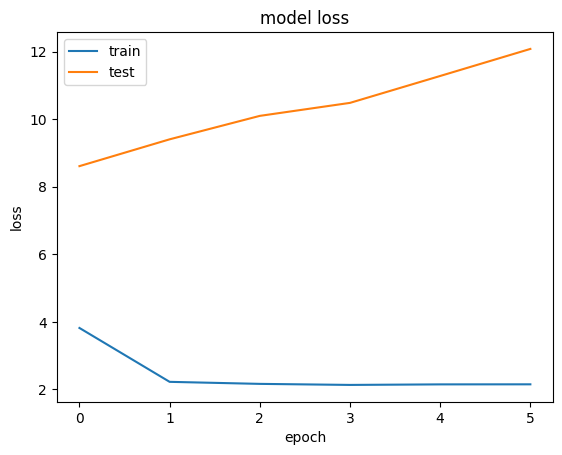

In [20]:
plot(train_losses2, test_losses2, title="model loss", y_label="loss")

In [21]:
sub_modules = []
for module in list(model2.features.modules()):
    if len(list(module.children())) == 0 and not isinstance(module, nn.BatchNorm2d):
        sub_modules.append(module)

for module in sub_modules[-20:]:
    for parameter in module.parameters():
        parameter.requires_grad = True

In [22]:
train_losses3, train_accuracies3, test_losses3, test_accuracies3 = run(model2, normal_init=True, learning_rate=1e-5)

100%|██████████| 515/515 [02:12<00:00,  3.89it/s]


Epoch: 1/10 | Train loss: 4.7438 | Train Acc: 0.0092 | Test loss: 4.8194 | Test Acc: 0.0000


100%|██████████| 515/515 [02:10<00:00,  3.96it/s]


Epoch: 2/10 | Train loss: 4.5904 | Train Acc: 0.0083 | Test loss: 4.8247 | Test Acc: 0.0000


100%|██████████| 515/515 [02:11<00:00,  3.92it/s]


Epoch: 3/10 | Train loss: 4.4170 | Train Acc: 0.0114 | Test loss: 4.8332 | Test Acc: 0.0000


100%|██████████| 515/515 [02:10<00:00,  3.94it/s]


Epoch: 4/10 | Train loss: 4.2286 | Train Acc: 0.0157 | Test loss: 4.8489 | Test Acc: 0.0000


100%|██████████| 515/515 [02:09<00:00,  3.97it/s]


Epoch: 5/10 | Train loss: 4.0326 | Train Acc: 0.0159 | Test loss: 4.8708 | Test Acc: 0.0000


100%|██████████| 515/515 [02:10<00:00,  3.95it/s]


Epoch: 6/10 | Train loss: 3.8354 | Train Acc: 0.0195 | Test loss: 4.9077 | Test Acc: 0.0000
Early stopping, best accuracy 0.0


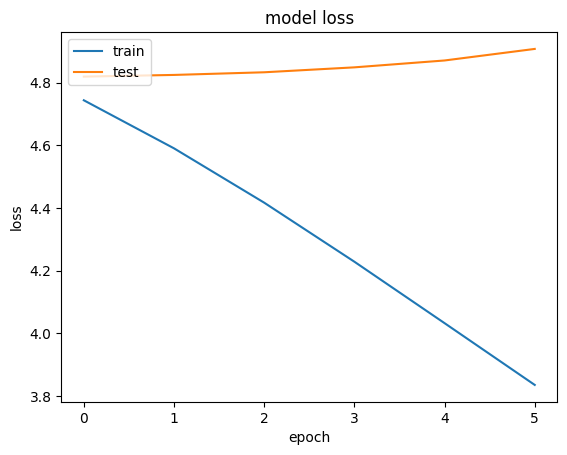

In [23]:
plot(train_losses3, test_losses3, title="model loss", y_label="loss")